In [ ]:
!pip install pytorch_lightning
!pip install tensorboardX
!pip install faiss-gpu

In [ ]:
from google.colab import drive
drive.mount("/gdrive", force_remount=True)

In [ ]:
import pandas as pd
import numpy as np
from collections import namedtuple

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as td

import pytorch_lightning as pl

from tqdm.autonotebook import tqdm
import json
import sklearn.metrics as sm

import tensorboardX as tb
import tensorflow as tf
import datetime, os

import matplotlib.pyplot as plt
import seaborn as sns

import typing as tp
import faiss
from sklearn.metrics.pairwise import euclidean_distances
from functools import partial
import shutil

np.random.seed(31337)

## Нейросетевой отборщик кандидатов
* Нужен, чтобы быстро найти кандидатов для юзера
* Обучается с помощью лосса, который учитывает близость эмбеддингов, а не скоры

#### Проблема:
Допустим, мы обучаем модель, которая ранжирует кандидатов. Отскорить всех кандидатов в real-time мы сможем за O(N). Это не подходит, если кандидатов очень много. Поэтому будем использовать приближенный поиск соседей (LSH, FAISS etc). При этом соседей мы будем находить по расстоянию между вектором юзера и векторами кандиадтов.

### Решение:
Давайте обучим отдельную модель -- отборщика кандидатов -- которая будет качественно искать ближайших соседей. Для этого смоделируем релевантность с помощью любой метрики, отражающей близость векторов.



### DSSM:
[DSSM](https://kishorepv.github.io/DSSM/) модель "сближает" эмбеддинги юзера и позитивных айтемов и "раздвигает" эмбеддинги юзера и негативных айтемов.

#### Архитектура:
1.   **ItemModel**: FF нейросеть, которая маппит фичи айтема в латентное пространство модели
2.   **UserModel**: FF нейросеть, которая маппит фичи юзера в латентное пространство модели  
3.   **Loss**: Triplet loss

В кчаестве фичей айтемов будем использовать доступные нам фичи: популярность, жанр. В качестве фичей юзеров будем использовать multi-hot вектора из матрицы интеракций.

Если фичей айтемов и юзеров нет, то можно сделать one-hot кодирование, имея айди юзера и айтемов.


### Triplet loss

$${\displaystyle {\mathcal {L}}\left(A,P,N\right)=\operatorname {max} \left({\|\operatorname {f} \left(A\right)-\operatorname {f} \left(P\right)\|}_{2}-{\|\operatorname {f} \left(A\right)-\operatorname {f} \left(N\right)\|}_{2}+\alpha ,0\right)}$$

${f}(A)$ - эмбеддинг юзера,

${f}(P)$ - эмбеддинг позитивного айтема,

${f}(N)$ - эмбеддинг негативного айтема

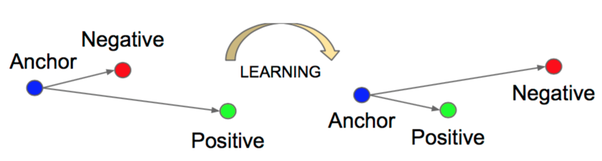

### Сбор данных
* Триплеты: юзер, позитивный айтем, негативный айтем
* Фичи юзера: матрица интеракций
* Фичи айтемов: ohe категориальные фичи

In [ ]:
data =  pd.read_csv("/gdrive/MyDrive/RecSys_Data/1600kfeedbacks.csv")
track_metadata = pd.read_json("/gdrive/MyDrive/RecSys_Data/tracks.json", lines=True).drop_duplicates(subset=["track"])

Отберем позитивные интеракции для фичей юзера

In [ ]:
positives = data[data["time"] > 0.8].copy()

track_counts = positives.groupby("track").size()
tracks = set(track_counts[track_counts >= 20].index.values)

data_filt = positives[positives["track"].isin(tracks)]

len(data_filt), len(tracks)

In [ ]:
interactions = pd.pivot_table(data_filt, values="time", index="user", columns="track").fillna(0)

print("Interactions matrix: \nshape=" + str(interactions.shape))
print("Sparsity=" + str((interactions != 0).values.sum() / interactions.size))

Отберем фичи айтемов: популярность и жанр

In [ ]:
track_metadata.shape, track_metadata.isnull().sum(axis = 0)

In [ ]:
track_metadata = track_metadata.fillna(value={'genre': 'Unk'})

In [ ]:
dummy_features = pd.get_dummies(track_metadata[["genre"]])
item_features = pd.concat([track_metadata[["track", "pop"]], dummy_features], axis=1).set_index("track", drop=True)
item_features['pop'] = np.log(item_features['pop'])
item_features.shape

Соберем трейн сразу по тройкам объектов:

uid, iid_pos, iid_neg

* pos - позитивный айтем из сессиии
* neg - случайный айтем из всего каталога

In [ ]:
triplets = data_filt[["user", "track"]].rename(columns={"track": "track_pos"})

In [ ]:
NUM_NEGATIVE_SAMPLES = 10
triplets =  pd.concat([triplets] * NUM_NEGATIVE_SAMPLES).sort_index().reset_index(drop=True)
triplets["track_neg"] = np.random.choice(range(50000), len(triplets))

Разобьем тройки на train, val, test

In [ ]:
rdm = np.random.random(len(triplets))
train_data = triplets[rdm < 0.8]
val_data = triplets[(rdm >= 0.8) & (rdm < 0.9)]
test_data = triplets[rdm >= 0.9]

len(train_data), len(val_data), len(test_data)

In [ ]:
item_features.shape, interactions.shape

In [ ]:
from random import shuffle

def pad_with_specific_value(lst, size, val):
    lst = list(set(lst))
    shuffle(lst)
    lst = lst[:size]
    return np.pad(lst, (0, size - len(lst)), 'constant', constant_values=(val))

padded_users = triplets.groupby("user").apply(lambda x: (
    pad_with_specific_value(x['track_pos'].tolist(), 30, 50000).tolist()
))

padded_users = padded_users.reindex(range(10000), fill_value=[50000] * 30)
padded_users = np.stack(padded_users.values)

In [ ]:
padded_users

### Создаем датасет для оубчения

Он должен возвращать 3 тензора:

*   user_feaures
*   item_features_pos
*   item_features_neg



In [ ]:
class DSSMData(pl.LightningDataModule):
  def __init__(self, train_triplets, val_triplets, test_triplets, item_features, padded_users):
      super().__init__()
      self.train_triplets = train_triplets
      self.val_triplets = val_triplets
      self.test_triplets = test_triplets
      self.item_features = item_features
      self.padded_users = padded_users

  def _collect_data(self, triplets):
      users = triplets["user"].values
      positives = triplets["track_pos"].values
      negatives = triplets["track_neg"].values

      # Wipe out positive interacted tracks from user listen history
      listened_tracks = self.padded_users[users]
      listened_tracks[listened_tracks == positives.reshape(-1, 1)] = 50000
      listened_tracks[listened_tracks == negatives.reshape(-1, 1)] = 50000

      return td.TensorDataset(
            torch.from_numpy(listened_tracks).long(),
            torch.from_numpy(item_features.loc[positives].values).double(),
            torch.from_numpy(item_features.loc[negatives].values).double()
      )

  def prepare_data(self, stage=None):
      if stage == "fit" or stage is None:
        self.train_dataset = self._collect_data(self.train_triplets)
        self.val_dataset = self._collect_data(self.val_triplets)
      elif stage == "test" or stage is None:
        self.test_dataset = self._collect_data(self.test_triplets)

  def train_dataloader(self):
      return td.DataLoader(self.train_dataset, batch_size=2048, shuffle=True, num_workers=0)

  def val_dataloader(self):
      return td.DataLoader(self.val_dataset, batch_size=2048, num_workers=0)

  def test_dataloader(self):
      return td.DataLoader(self.test_dataset, batch_size=2048, shuffle=False, num_workers=0)

### DSSM-модель

In [ ]:
class DSSM(pl.LightningModule):
    def __init__(
        self,
        dim_item_features: int,
        item_number: int,
        embedding_dim: int = 100,
        activation: tp.Callable[[torch.Tensor], torch.Tensor] = F.relu,
        lr: float = 1e-3,
        triplet_loss_margin: float = 0.4,
        weight_decay: float = 1e-6,
        log_to_prog_bar: bool = True,
    ) -> None:
        super().__init__()
        self.lr = lr
        self.triplet_loss_margin = triplet_loss_margin
        self.weight_decay = weight_decay
        self.log_to_prog_bar = log_to_prog_bar
        self.item_net = ItemNet(embedding_dim, dim_item_features, activation)
        self.user_net = UserNet(embedding_dim, item_number)

    def forward(
        self,
        user_ids: torch.Tensor,
        item_features_pos: torch.Tensor,
        item_features_neg: torch.Tensor,
    ) -> tp.Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        anchor = self.user_net(user_ids)
        pos = self.item_net(item_features_pos)
        neg = self.item_net(item_features_neg)

        return anchor, pos, neg

    def _step(self, batch, batch_idx, metric, prog_bar=False):
        user_ids, pos, neg = batch
        anchor, positive, negative = self(user_ids, pos, neg)
        loss = F.triplet_margin_loss(anchor, positive, negative, margin=self.triplet_loss_margin)
        self.log(metric, loss, prog_bar=prog_bar)
        return loss

    def training_step(self, batch: tp.Sequence[torch.Tensor], batch_idx: int) -> torch.Tensor:
        return self._step(batch, batch_idx, "train_loss")

    def validation_step(self, batch: tp.Sequence[torch.Tensor], batch_idx: int) -> torch.Tensor:
        return self._step(batch, batch_idx, "val_loss", self.log_to_prog_bar)

    def test_step(self, batch, batch_idx, prog_bar=False):
        return self._step(batch, batch_idx, "test_loss", self.log_to_prog_bar)

    def inference(self, dataloader: td.DataLoader[tp.Any], mode: str = "item") -> np.ndarray:
        batches = []
        user_ids = []
        if(mode == "user"):
          model = self.user_net
        elif(mode == "item"):
          model = self.item_net
        else:
          raise ValueError(f"Unsupported model {mode}!")

        self.eval()
        for batch in dataloader:
            ids, features = batch
            with torch.no_grad():
                v_batch = model(features.to(self.device))
            batches.append(v_batch)
            user_ids.append(ids)
        vectors = torch.cat(batches, dim=0).cpu().numpy()
        vectors_ids = torch.cat(user_ids, dim=0).cpu().numpy()
        return vectors_ids, vectors

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr, weight_decay=self.weight_decay)
        lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, verbose=True)
        scheduler = {
            'scheduler': lr_scheduler,
            'monitor': 'val_loss'
        }
        return [optimizer], [scheduler]

In [ ]:
class ItemNet(nn.Module):
    def __init__(self, n_factors: int, dim_input: int, activation: tp.Callable[[torch.Tensor], torch.Tensor] = F.relu) -> None:
        super().__init__()
        self.embedding_layer = nn.Linear(dim_input - 1, 32, bias=False)
        self.dense_layer = nn.Linear(32 + 1, n_factors, bias=False)
        self.output_layer = nn.Linear(n_factors + 32, n_factors, bias=False)
        self.activation = activation

    def forward(self, item_features: torch.Tensor) -> torch.Tensor:
        popularity = item_features[:, 0].view(-1, 1)
        genre_emb = self.embedding_layer(item_features[:, 1:])

        pop_genre = torch.concat([popularity, genre_emb], axis=1)
        features = self.activation(self.dense_layer(pop_genre))

        genre_features = torch.concat([genre_emb, features], axis=1)
        output = self.output_layer(genre_features)
        return output

class UserNet(nn.Module):
    def __init__(self, n_factors: int, num_embeddings: int, activation: tp.Callable[[torch.Tensor], torch.Tensor] = F.relu) -> None:
        super().__init__()
        self.track_embeddings = nn.EmbeddingBag(num_embeddings+1, n_factors, padding_idx=num_embeddings)
        self.dense_layer = nn.Linear(n_factors, n_factors, bias=False)
        self.output_layer = nn.Linear(n_factors + n_factors, n_factors, bias=False)
        self.activation = activation

    def forward(self, user_tracks: torch.Tensor) -> torch.Tensor:
        interactions_emb = self.track_embeddings(user_tracks)
        features = self.activation(self.dense_layer(interactions_emb))
        x = torch.concat([interactions_emb, features], axis=1)
        output = self.output_layer(x)
        return output

Конфигурируем обучение

In [ ]:
data_module = DSSMData(train_data, val_data, test_data, item_features, padded_users)
net = DSSM(dim_item_features=23, item_number=50000, embedding_dim=64).double()

checkpoint_callback = pl.callbacks.ModelCheckpoint(monitor="val_loss")

trainer = pl.Trainer(
    max_epochs=30,
    accelerator='gpu',
    devices=1,
    callbacks=[
        pl.callbacks.early_stopping.EarlyStopping(monitor="val_loss", patience=5),
        pl.callbacks.LearningRateMonitor(logging_interval="step"),
        checkpoint_callback,
    ])

In [ ]:
trainer.fit(
    net,
    data_module
)

In [ ]:
shutil.move(checkpoint_callback.best_model_path, "/gdrive/MyDrive/RecSys_Data/dssm.ckpt")

In [ ]:
best = DSSM.load_from_checkpoint("/gdrive/MyDrive/RecSys_Data/dssm.ckpt", dim_item_features=23, item_number=50000, embedding_dim=64)

Инферим модель

In [ ]:
item_features = item_features.sort_index()
items = torch.from_numpy(item_features.index.values)
inf_items = torch.from_numpy(item_features.values).double()
items_ds = td.TensorDataset(items, inf_items)

In [ ]:
inf_dl_items = td.DataLoader(items_ds, batch_size=128, shuffle=False, num_workers=1)
track_ids, track_embeddings = best.double().inference(inf_dl_items)

In [ ]:
interactions = interactions.sort_index()
user_ids_inf = torch.from_numpy(interactions.index.values)
user_inf_feat = torch.from_numpy(padded_users[interactions.index.values]).long()
user_ds = td.TensorDataset(user_ids_inf, user_inf_feat)

In [ ]:
inf_dl_users = td.DataLoader(user_ds, batch_size=128, shuffle=False, num_workers=1)
user_ids, user_embeddings = best.double().inference(inf_dl_users, "user")

In [ ]:
track_embeddings.shape, user_embeddings.shape

In [ ]:
gpu_res = faiss.StandardGpuResources()
index_flat = faiss.index_factory(track_embeddings.shape[1], "Flat", faiss.METRIC_L2)

#index = faiss.index_cpu_to_gpu(gpu_res, 0, index_flat)
index = index_flat
index.add(track_embeddings.astype('float32'))

In [ ]:
k = 100
with open("/gdrive/MyDrive/RecSys_Data/dssm_recs_faiss.json", "w") as rf:
    for user, user_emb in tqdm(zip(user_ids, user_embeddings), total=len(user_ids)):
      dists, neighbours = index.search(user_emb.astype('float32')[np.newaxis, :], k)
      recommendation = {
            "user": int(user),
            "tracks": neighbours.flatten().tolist()
        }
      rf.write(json.dumps(recommendation) + "\n")

Записываем эмбеддинги и логи обучения

In [ ]:
writer = tb.SummaryWriter(comment='ncf_embeddings', log_dir="/gdrive/MyDrive/RecSys_Data/Week5Seminar/tb")
writer.add_embedding(track_embeddings, metadata=list(track_metadata[["artist", "title"]].itertuples(index=False, name=None)), tag="DSSM", metadata_header=["artist", "title"])
writer.close()

In [ ]:
!cp -r /content/lightning_logs /gdrive/MyDrive/RecSys_Data/Week5Seminar/lightning_logs